## Motivation: 1-D Poisson Equation
$$\frac{\partial^2 u}{\partial x^2} = -f(x), \quad x\in[0,1]$$
Here $f(x)$ is some forcing function. We also have boundary conditions on our solution function
$$u(0) = u(1) = 0$$

The general Poisson equation is denoted $\nabla^2 \phi = f(\mathbf{r})$ (where $\mathbf{r}$ is a position $(x,y,z)$) and arises in many areas of physics such as electrostatics and gravitation.

For now we focus on the 1-D variant so we can learn numerical methods of solving differential equations, as well as modern ways to solve said equations using Physics Informed Neural Networks (PINNs).



## Part 1 - Finite Difference Method (FDM)

The idea behind FDM is that we discretize our domain $[a,b]$ into $N$ equal intervals of width $h= \frac{b-a}{N}$.

We then use the values of the solutions at the end points to approximate a solution. Our grid points are $x_i = a + bi$ for $i = 0,...,N$

We solve for unknowns $u_i \approx u(x_i$), where $i$ represents the number of regions between 0 and 1. We don't need to calculate $u(x_0)=u(x_n)=0$ since those are our boundary conditions.

Intuitviely, we are replacing our derivatives with algebraic equations to get an approximate solution. These algebraic equations can usually come together in a nice matrix form.

The second derivative at an interior point $x_i$ is approximated using the central difference formula (with error proportional to $O(h^2)$)
$$\frac{\partial^2 u}{\partial x^2}\bigg|_{x_i} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2} = -f(x_i)$$

Rearranging gives $$u_{i-1} - 2u_i + u_{i+1} = -h^2 f(x_i), \quad i = 1, 2, \dots, N-1$$

Our system can be written as $A\mathbf{u}=\mathbf{b}$ as shown below
$$
\begin{bmatrix}
-2 & 1 & & & \\
1  & -2 & 1 & & \\
   & 1  & -2 & \ddots & \\
   &    & \ddots & \ddots & 1 \\
   &    &        & 1 & -2
\end{bmatrix}
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
-h^2 f(x_1) - u_0 \\
-h^2 f(x_2) \\
-h^2 f(x_3) \\
\vdots \\
-h^2 f(x_{n-1}) - u_n
\end{bmatrix}
$$

Now let's get into the code for a numerical solver!

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

def poisson_1d_fdm(a, b, N, f, ua, ub):
  """
    Solve 1D Poisson equation u'' = -f(x) on [a,b] with u(a)=ua, u(b)=ub using FDM

    Parameters:
    - a, b: interval endpoints
    - N: number of subintervals
    - f: source function (callable)
    - ua, ub: Dirichlet BCs at a and b

    Returns:
    - x: grid points (array)
    - u: solution at grid points (array)
  """
  h = (b - a) / N
  x = np.linspace(a, b, N+1) # Discretize the interval

  # Initalize our matrix
  diag = -2 * np.ones(N-1)
  off_diag = np.ones(N-2)
  A = np.diag(diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)

  # Adjust for boundary conditions (note: -h**2 because u'' = -f)
  fx = f(x[1:-1])
  rhs = -h**2 * fx
  rhs[0] -= ua
  rhs[-1] -= ub

  # Solve our system (scipy is clutch)
  u_interior = solve(A, rhs)

  u = np.zeros(N+1)
  u[0] = ua
  u[-1] = ub
  u[1:-1] = u_interior

  return x, u


### Example
Let's solve this 1-D Poisson equation with our numerical solver $$\frac{\partial^2 u}{\partial x^2} = - \pi^2 \sin(\pi x)$$

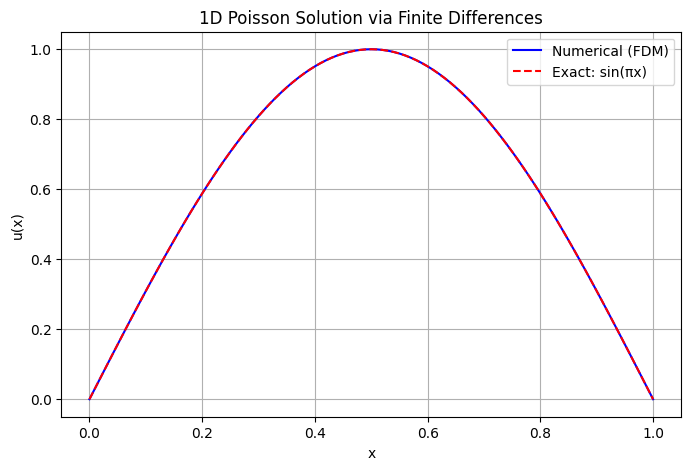

Max error with N=100: 0.0082%


In [11]:
def example_func(x):
  return np.pi**2 * np.sin(np.pi * x)

a, b = 0.0, 1.0
ua, ub = 0.0, 0.0
N = 100 # Grid resolution

x, u_num = poisson_1d_fdm(a, b, N, example_func, ua, ub)

# Exact solution for comparison
u_exact = np.sin(np.pi * x)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, u_num, 'b-', label='Numerical (FDM)')
plt.plot(x, u_exact, 'r--', label='Exact: sin(πx)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('1D Poisson Solution via Finite Differences')
plt.legend()
plt.grid(True)
plt.show()

# Compute max error
error = np.max(np.abs(u_num - u_exact))
error_percent = 100.0 * error / np.max(np.abs(u_exact))
print(f"Max error with N={N}: {error_percent:.4f}%")

## That looks like a really good approximation... isn't that enough?
While FDMs work well for low-dimensional PDEs and ODEs, as dimensions scale up we quickly see the common "curse of dimensionality" arise.

In the case of inverse problems, FDMs also become very computationally expensive, requiring many forward solves and optimizations.

## What's the solution?
It's not an exact solution (lol), but Physics Informed Neural Networks were developed in the 2010s to use ideas from machine learning and neural network architectures to solve these kinds of PDEs.

The field of physics-informed machine learning is an actively growing one, and many innovations to the field have arised (such as the Neural Operator which I hope to experiment with soon) and have solved problems in engineering, biology and physics.

Common approaches to PINNs actually combine techniques from machine learning and numerical methods to arrive at the "best" solution given reasonable compute efficiency.

## Part 2: How can we apply PINNs to our problem?
We can approximate a solution to the 1-D Poisson equation as follows:
$$\hat{u}_\theta(x) \approx u(x)$$

our PINN is a function approximator $\hat{u}$ that takes parameters $\theta$ (these parameters are the weights and biases of our neural network).

Our loss function is a combination of the residual loss on our PDE, recall that $\frac{\partial^2 u}{\partial x^2} = -f(x)$ so our total mean-squared residual loss here is
$$
L_{\text{PDE}}(\theta) = \frac{1}{N} \sum_i \left( \frac{\partial^2 \hat{u}_{\theta}}{\partial x^2}\bigg|_{x = x_i} + f(x_i) \right)^2
$$

$x_i \sim U(0,1)$ is a random collocation point within our interval in which we will evaluate our second derivative and forcing function.

We must also calculate the residual loss at the boundary points:
$$
L_{\text{BC}}(\theta) =
\frac{1}{2} \left[
\left( \hat{u}_\theta(0) - u(0) \right)^2 +
\left( \hat{u}_\theta(1) - u(1) \right)^2
\right]
$$

Thus, our total loss function is $$L(\theta) = L_{PDE}(\theta) + L_{BC}(\theta) $$

Great! Now we can move on to our training loop.
We will use a gradient-based optimizer like ADAM to minimize our loss function: 
$$
\theta^* = \arg\min_\theta {L}(\theta) = \arg\min_\theta \Bigl({L}_{\text{PDE}}(\theta) + {L}_{\text{BC}}(\theta) \Bigr)
$$

while computing derivatives using higher-order automatic differentiation (AKA letting the JAX compiler do the work).

We can now go about implementidng our PINN as a simple multi-layer perceptron!

In [3]:
pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.6 MB/s eta 0:00:00


step=0, loss=4.798206e+01
step=1000, loss=1.766979e-03
step=2000, loss=1.015892e-03
step=3000, loss=2.090249e-04
step=4000, loss=8.489193e-04
step=5000, loss=2.881647e-04
step=6000, loss=2.954331e-04
step=7000, loss=5.514553e-04
step=8000, loss=1.401544e-04
step=9000, loss=2.293753e-05
step=9999, loss=4.794074e-05
Results:
  Max absolute error: 0.1973%
  Relative L2 error:  0.2172%


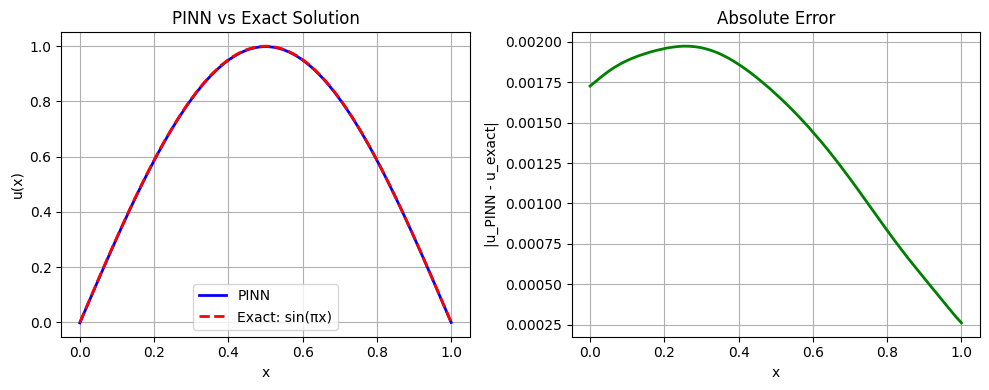

In [16]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

# Source function and exact solution
def source_f(x):
    return (jnp.pi ** 2) * jnp.sin(jnp.pi * x)

def exact_solution(x):
    return jnp.sin(jnp.pi * x)

# Define model architecture
class PINN(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, key):
        self.mlp = eqx.nn.MLP(
            in_size=1,
            out_size=1,
            width_size=50,
            depth=3,
            activation=jax.nn.tanh,
            key=key,
        )

    def __call__(self, x):
        return self.mlp(x)

def u_at_x(model, x_scalar):
    """
    Evaluate u(x) where x is a JAX scalar.
    Returns a scalar.
    """
    x_arr = jnp.atleast_1d(x_scalar)  # shape (1,)
    return model(x_arr)[0]            # scalar

# Loss functions
def pde_loss(model, x_colloc):
    def single_residual(x):
        def u(x_scalar):
            return u_at_x(model, x_scalar)
        
        # Second derivative at point x
        d2u_dx2 = jax.grad(jax.grad(u))(x)

        return d2u_dx2 + source_f(x)
    
    residuals = jax.vmap(single_residual)(x_colloc)
    return jnp.mean(residuals ** 2)

def bc_loss(model, u_a=0.0, u_b=0.0):
    u0 = u_at_x(model, 0.0)
    u1 = u_at_x(model, 1.0)
    return 0.5 * ((u0 - u_a) ** 2 + (u1 - u_b) ** 2)

def total_loss(model, x_colloc):
    return pde_loss(model, x_colloc) + bc_loss(model)

# Training loop
def main(
    steps=10000,
    learning_rate=1e-3,
    n_colloc=2048,
    print_every=1000,
    seed=42,
):
    key = jax.random.PRNGKey(seed)
    model_key, key = jax.random.split(key)
    
    # Initialize model and optimizer
    model = PINN(model_key)
    optim = optax.adam(learning_rate)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        # Sample collocation points in (0, 1)
        x_colloc = jax.random.uniform(key, (n_colloc,))
        
        # Compute loss and gradients w.r.t. model parameters
        loss, grads = eqx.filter_value_and_grad(total_loss)(model, x_colloc)
        
        # Update model
        updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        
        return loss, model, opt_state

    # Training loop
    for step in range(steps):
        key, subkey = jax.random.split(key)
        loss, model, opt_state = make_step(model, opt_state, subkey)
        if step % print_every == 0 or step == steps - 1:
            print(f"step={step}, loss={loss.item():.6e}")

    return model

# Model evaluation and plotting
def evaluate(model, n_points=200):
    x_eval = jnp.linspace(0, 1, n_points)
    u_pred = jax.vmap(lambda x: u_at_x(model, x))(x_eval)
    u_exact = exact_solution(x_eval)
    
    # Compute errors
    abs_error = jnp.abs(u_pred - u_exact)
    max_abs_error = jnp.max(abs_error).item()
    max_abs_error_pct = 100.0 * max_abs_error / jnp.max(jnp.abs(u_exact)).item()
    l2_rel_error = jnp.sqrt(jnp.mean((u_pred - u_exact)**2)) / jnp.sqrt(jnp.mean(u_exact**2))
    
    print(f"Results:")
    print(f"  Max absolute error: {max_abs_error_pct:.4f}%")
    print(f"  Relative L2 error:  {100 * l2_rel_error:.4f}%")
    
    return x_eval, u_pred, u_exact


def plot_results(model, n_points=200):
    x_eval, u_pred, u_exact = evaluate(model, n_points)
    abs_error = jnp.abs(u_pred - u_exact)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(x_eval, u_pred, 'b-', label='PINN', linewidth=2)
    plt.plot(x_eval, u_exact, 'r--', label='Exact: sin(πx)', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('PINN vs Exact Solution')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(x_eval, abs_error, 'g-', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('|u_PINN - u_exact|')
    plt.title('Absolute Error')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Run training and plot results
model = main()
plot_results(model)